In [2]:
import zipfile
import os
from google.colab import drive

# Authenticate and mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 224 validated image filenames.
Found 224 validated image filenames.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/1500
14/14 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.1588 - loss: 0.1103 - psnr: 9.6399 - ssim_metric: 0.0573 - val_accuracy: 0.1338 - val_loss: 0.1037 - val_psnr: 9.9579 - val_ssim_metric: 0.0823
Epoch 2/1500
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.1527 - loss: 0.0993 - psnr: 10.2350 - ssim_metric: 0.0890 - val_accuracy: 0.1856 - val_loss: 0.0825 - val_psnr: 11.1353 - val_ssim_metric: 0.1193
Epoch 3/1500
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 731ms/step - accuracy: 0.2446 - loss: 0.0664 - psnr: 11.8699 - ssim_metric: 0.1109 - val_accuracy: 0.2084 - val_loss: 0.0643 - val_psnr: 11.9921 - val_ssim_metric: 0.1501
Epoch 4/1500
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.2377 - loss: 0.0664 - psnr: 11.8932 - ssim_metric: 0.1264 - val_accuracy: 0.1944 - val_loss: 0.0700 - val_psnr: 11.7874 - val_ssim_metric: 0.1483
Epoch 5/1500
14/14 ━━━━━

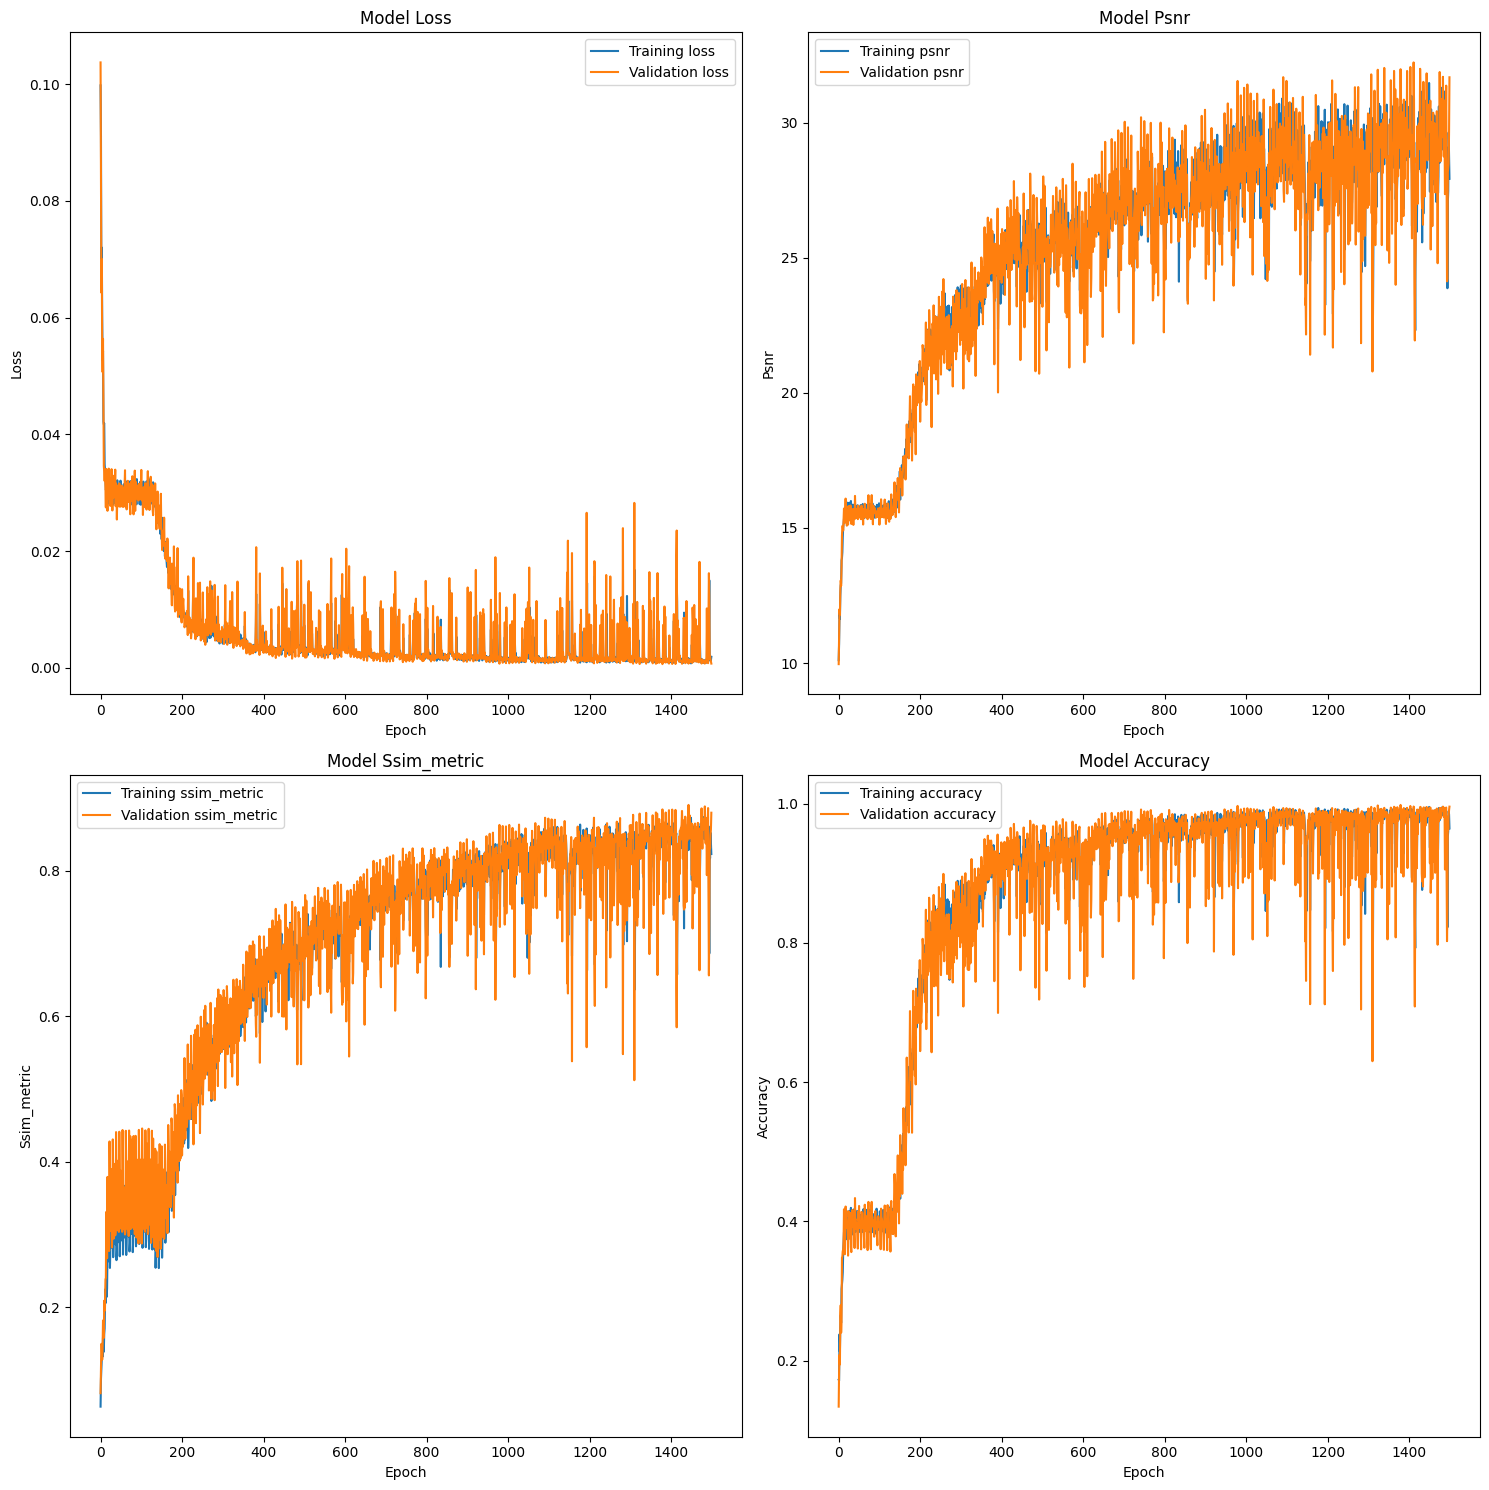

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9862 - loss: 0.0013 - psnr: 28.8308 - ssim_metric: 0.8489
Test Loss: 0.0013
Test PSNR: 29.0366
Test SSIM: 0.8593
Test Accuracy: 0.9872


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
PSNR: 29.3352
SSIM: 0.7794


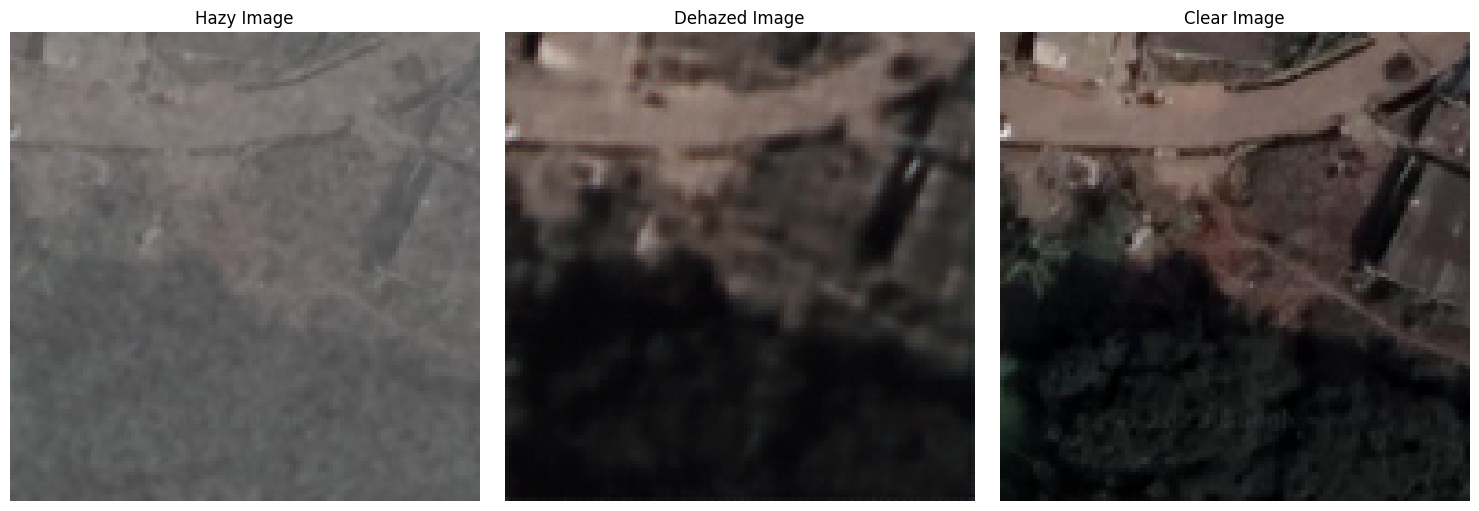

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import pandas as pd
import os

# GPU memory management (for low GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)

# Directories
hazy_image_dir = '/content/drive/MyDrive/Preprocessed_Hazy_Images'
clear_image_dir = '/content/drive/MyDrive/Preprocessed_Clear_Images'

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128

# Data Generator
datagen = ImageDataGenerator(rescale=1./255)

# Create list of file paths for hazy and clear images
hazy_images = [os.path.join(hazy_image_dir, fname) for fname in os.listdir(hazy_image_dir) if fname.endswith('.tif')]
clear_images = [os.path.join(clear_image_dir, fname) for fname in os.listdir(clear_image_dir) if fname.endswith('.tif')]

# Create a dataframe
df = pd.DataFrame({
    'filename': hazy_images + clear_images,
    'label': ['hazy'] * len(hazy_images) + ['clear'] * len(clear_images)
})

# Create data generators
hazy_generator = datagen.flow_from_dataframe(
    dataframe=df[df['label'] == 'hazy'],
    x_col='filename',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=4,
    class_mode=None,
    shuffle=False
)

clear_generator = datagen.flow_from_dataframe(
    dataframe=df[df['label'] == 'clear'],
    x_col='filename',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=4,
    class_mode=None,
    shuffle=False
)

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs): # Add **kwargs
        super(TransformerBlock, self).__init__(**kwargs) # Pass **kwargs to super
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):  # Add get_config method
        config = super(TransformerBlock, self).get_config()
        config.update({
            'embed_dim': self.att.key_dim,
            'num_heads': self.att.num_heads,
            'ff_dim': self.ffn.layers[0].units,  # Assuming ff_dim is the units of the first Dense layer in ffn
            'rate': self.dropout1.rate
        })
        return config

# def dehazing_model(input_shape=(128, 128, 3), training=False):
#     input_layer = layers.Input(shape=input_shape)

#     # ResNet50V2 as the base model
#     base_model = ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_layer)
#     base_model.trainable = False

#     x = base_model.output
#     x = layers.Conv2D(512, (1, 1), activation='relu')(x)
#     x = TransformerBlock(512, 2, 128)(x, training=training)
#     x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
#     x = TransformerBlock(256, 2, 64)(x, training=training)
#     x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
#     x = TransformerBlock(128, 2, 32)(x, training=training)
#     x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)

#     # Add final upsampling layer to match input shape
#     x = layers.Conv2DTranspose(3, 3, strides=2, padding='same', activation='relu')(x)
#     #x = layers.Reshape((128, 128, 3))(x)  # Reshape the output to match the input shape

#     output = layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)

#     model = Model(inputs=input_layer, outputs=output)
#     return model
def dehazing_model(input_shape=(128, 128, 3), training=False):
    input_layer = layers.Input(shape=input_shape)

    # ResNet50V2 as the base model
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_layer)
    base_model.trainable = False

    x = base_model.output  # Shape will be something like (4, 4, 2048)

    # Apply a Conv2D layer to reduce the number of channels
    x = layers.Conv2D(512, (1, 1), activation='relu')(x)

    # Transformer block after Conv2D
    x = TransformerBlock(512, 2, 128)(x, training=training)

    # Upsample to match the input size
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)  # 8x8
    x = TransformerBlock(256, 2, 64)(x, training=training)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)  # 16x16
    x = TransformerBlock(128, 2, 32)(x, training=training)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)  # 32x32
    x = TransformerBlock(64, 2, 16)(x, training=training)

    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)  # 64x64
    x = TransformerBlock(32, 2, 16)(x, training=training)

    # Final upsampling to reach 128x128
    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)  # 128x128

    # Output layer
    output = layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)  # Final output is 128x128x3

    model = Model(inputs=input_layer, outputs=output)
    return model



# Calculate the current shape of x dynamically
    current_shape = x.shape[1:]

    # Ensure the output matches the input shape
    x = layers.Reshape(target_shape=current_shape)(x)

    output = layers.Conv2D(3, 3, padding='same', activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model

# Define metrics
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

def accuracy(y_true, y_pred):
    # For image data, we can consider a pixel "correct" if it's within a certain threshold
    threshold = 0.1
    return tf.reduce_mean(tf.cast(tf.abs(y_true - y_pred) < threshold, tf.float32))

# Create and compile the model
model = dehazing_model()
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=MeanSquaredError(),
              metrics=[psnr, ssim_metric, accuracy])

# Define a generator that yields pairs of hazy and clear images
def image_pair_generator(hazy_generator, clear_generator):
    while True:
        hazy_images = next(hazy_generator)
        clear_images = next(clear_generator)
        yield hazy_images, clear_images

# Train the model
BATCH_SIZE = 2
GRADIENT_ACCUMULATION_STEPS = 4

history = model.fit(
    image_pair_generator(hazy_generator, clear_generator),
    epochs=1500,
    steps_per_epoch=len(hazy_generator) // GRADIENT_ACCUMULATION_STEPS,
    validation_data=image_pair_generator(hazy_generator, clear_generator),
    validation_steps=len(clear_generator) // (2 * GRADIENT_ACCUMULATION_STEPS)
)

# Save the model
model.save('dehazing_model.h5')

# Plot training history
import matplotlib.pyplot as plt

metrics = ['loss', 'psnr', 'ssim_metric', 'accuracy']
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, metric in enumerate(metrics):
    ax = axs[i//2, i%2]
    ax.plot(history.history[metric], label=f'Training {metric}')
    ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    ax.set_title(f'Model {metric.capitalize()}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.capitalize())
    ax.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_psnr, test_ssim, test_accuracy = model.evaluate(
    image_pair_generator(hazy_generator, clear_generator),
    steps=len(clear_generator) // GRADIENT_ACCUMULATION_STEPS
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test PSNR: {test_psnr:.4f}")
print(f"Test SSIM: {test_ssim:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

import tensorflow as tf
import numpy as np
import os
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from PIL import Image

# Load the trained model
model = load_model('dehazing_model.h5', custom_objects={
    'psnr': tf.image.psnr,
    'ssim_metric': tf.image.ssim,
    'accuracy': lambda y_true, y_pred: tf.reduce_mean(tf.cast(tf.abs(y_true - y_pred) < 0.1, tf.float32)),
    'TransformerBlock': TransformerBlock
})

# Set paths
hazy_dir = '/content/drive/MyDrive/Hazy_Images/Hazy_img'
clear_dir = '/content/drive/MyDrive/Clear_Images/Clear_imgs'

# Get list of image files
hazy_files = [f for f in os.listdir(hazy_dir) if f.endswith('.tif')]

# Select a random image
random_file = random.choice(hazy_files)
hazy_path = os.path.join(hazy_dir, random_file)
clear_path = os.path.join(clear_dir, random_file)  # Assuming clear images have the same filename

# Load and preprocess the images
def load_and_preprocess(image_path):
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    return img_array

hazy_image = load_and_preprocess(hazy_path)
clear_image = load_and_preprocess(clear_path)

# Dehaze the image
dehazed_image = model.predict(np.expand_dims(hazy_image, axis=0))[0]

# Calculate PSNR and SSIM
psnr = tf.image.psnr(clear_image, dehazed_image, max_val=1.0)
ssim = tf.image.ssim(clear_image, dehazed_image, max_val=1.0)

print(f"PSNR: {psnr.numpy():.4f}")
print(f"SSIM: {ssim.numpy():.4f}")

# Display images
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(hazy_image)
plt.title('Hazy Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(dehazed_image)
plt.title('Dehazed Image')
plt.axis('off')

plt.subplot(133)
plt.imshow(clear_image)
plt.title('Clear Image')
plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
PSNR: 26.9829
SSIM: 0.8293


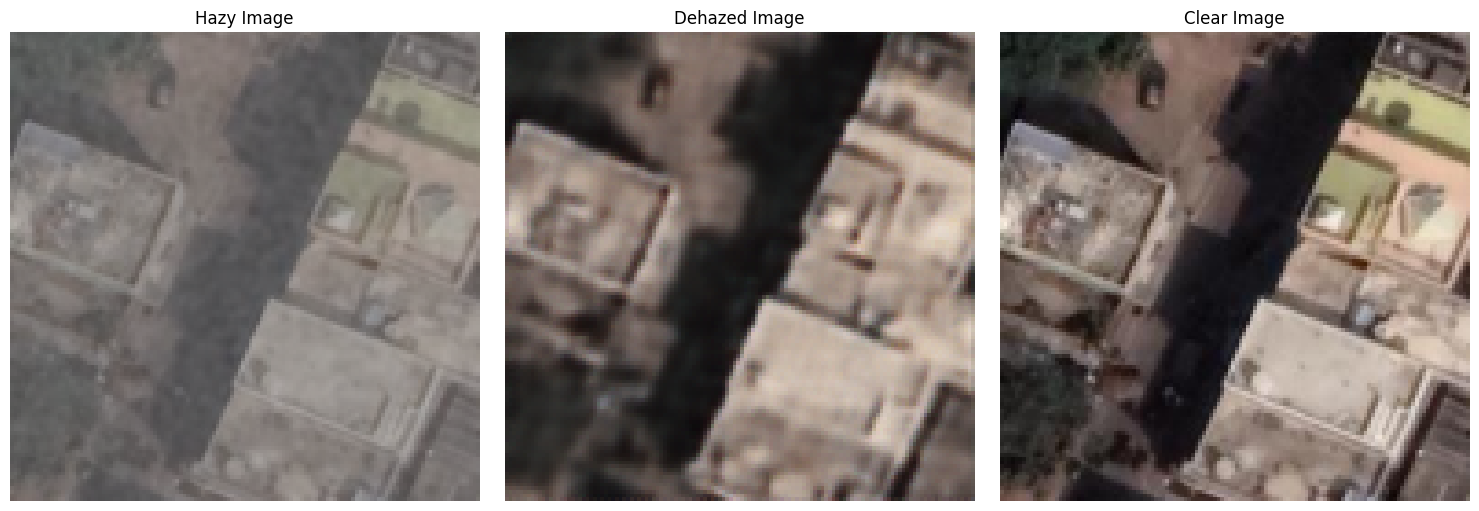

In [10]:
# Manually specify the image file
selected_file = '0099.tif'  # Replace this with your desired image name
hazy_path = os.path.join(hazy_dir, selected_file)
clear_path = os.path.join(clear_dir, selected_file)  # Assuming clear images have the same filename

# Load and preprocess the images
def load_and_preprocess(image_path):
    img = load_img(image_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0
    return img_array

hazy_image = load_and_preprocess(hazy_path)
clear_image = load_and_preprocess(clear_path)

# Dehaze the image
dehazed_image = model.predict(np.expand_dims(hazy_image, axis=0))[0]

# Calculate PSNR and SSIM
psnr = tf.image.psnr(clear_image, dehazed_image, max_val=1.0)
ssim = tf.image.ssim(clear_image, dehazed_image, max_val=1.0)

print(f"PSNR: {psnr.numpy():.4f}")
print(f"SSIM: {ssim.numpy():.4f}")

# Display images
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(hazy_image)
plt.title('Hazy Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(dehazed_image)
plt.title('Dehazed Image')
plt.axis('off')

plt.subplot(133)
plt.imshow(clear_image)
plt.title('Clear Image')
plt.axis('off')

plt.tight_layout()
plt.show()